In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

from tqdm.auto import tqdm

In [2]:
from darts import TimeSeries
from darts.metrics import mape, mase, rmse, mae, smape, mse

from darts.utils.missing_values import fill_missing_values

## Prepare Dataset

In [3]:
#Default settings for experiment
arg_model = "tsrnn" #Options: 'trfbb', 'tsrnn', 'trfbf'
arg_dset = "aep" #Datasets -- Spain: 'ree', AEP, DAYTON: 'dyt' London: 'lsm'

attr_dset_smpl_rt = 24 if arg_dset == "aep" else (48 if arg_dset == "lsm" else 24) #Samples per day. Spain, AEP: 24, London: 48
# param_dset_lookback_weeks = 5
# param_dset_forecast = 48 if arg_dset == "lsm" else 24
param_dset_lookback_weeks = 9
param_dset_forecast = 168 if arg_dset == "lsm" else 84 # 3.5days = 168
param_dset_train_stride = 48 #Choose a coprime value to the forecast so all reading frames are eventually considered
param_dset_test_stride = 'same' #tsrnn paper uses 1 week
param_dset_lookback = param_dset_lookback_weeks*7*attr_dset_smpl_rt - param_dset_forecast

param_trf_weather = False



In [4]:
from PJM_energy_datasets.aep_def import AEP

#Compute remaining settings
param_dset_lookback = param_dset_lookback_weeks*7*attr_dset_smpl_rt - param_dset_forecast
if param_dset_train_stride == 'same': param_dset_train_stride = param_dset_forecast
if param_dset_test_stride == 'same': param_dset_test_stride = param_dset_forecast
attr_dset_smpl_rt = {'ree':24,'aep':24,'lsm':48, 'dyt':24}[arg_dset]

param_trf_inp_dim = {'ree':7,'lsm': 14}[arg_dset] if param_trf_weather else 1

In [5]:
#Setup Dataset
train_set = val_set = test_set = None
if arg_dset == 'aep':
    train_offset = 0
    val_offset = 9 
    #with the definitions for split boundaries, this offset for the start of the validation set ensures the start time matches the train and test sets.
    train_set = AEP(path = "PJM_energy_datasets/",
                    start_idx = train_offset, end_idx = (4042*24)+param_dset_forecast - 12129,
                    seq_len = param_dset_lookback,
                    pred_horz = param_dset_forecast,
                    stride=param_dset_train_stride,
                    timestamp = False)
    val_set = AEP(path = "PJM_energy_datasets/",
                  start_idx = val_offset + (4042*24)+param_dset_forecast - 12129,
                  end_idx = (4042*24)+param_dset_forecast,
                    seq_len = param_dset_lookback,
                    pred_horz = param_dset_forecast,
                    stride=param_dset_train_stride,
                    timestamp = False)
    test_set = AEP(path = "PJM_energy_datasets/",
                    start_idx = (4042*24)+param_dset_forecast, #~Last 20% of dataset
                    seq_len = param_dset_lookback,
                    pred_horz = param_dset_forecast,
                    stride=param_dset_test_stride,
                    timestamp = False)

    #Monkey patch the dataset to normalize the series
    train_set.series = (train_set.series - 9581)/(25695 - 9581)
    val_set.series = (val_set.series - 9581)/(25695 - 9581)
    test_set.series = (test_set.series - 9581)/(25695 - 9581)

print(train_set.series.shape)
print(test_set.series.shape)

torch.Size([1739, 1512, 1])
torch.Size([271, 1512, 1])


## Import Models for comparison

In [6]:
#Importing the testing models
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    VARIMA,
    BATS,
    TBATS,
    StatsForecastAutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FourTheta,
    FFT,
    NBEATSModel,
    TFTModel,
    RNNModel,
    TransformerModel,
)

Importing plotly failed. Interactive plots will not work.


In [7]:
def eval_model(model, train, val, f=None ):
    model.fit(train)
    forecast = model.predict(len(val))
    mseRes = mse(val, forecast)
    rmseRes = rmse(val, forecast)
    # mapeRes = mape(val, forecast)
    maeRes = mae(val, forecast)
    smapeRes = smape(val, forecast)
    # maseRes = mase(val, forecast,train)
    
    # print('model {} obtains MSE: {:.6f}'.format(model,mseRes))
    # print('model {} obtains RMSE: {:.6f}'.format(model,rmseRes))
    # # print('model {} obtains MAPE: {:.6f}'.format(model,mapeRes ))
    # print('model {} obtains MAE: {:.6f}'.format(model, maeRes))
    # print('model {} obtains SMAPE: {:.6f}'.format(model,smapeRes ))
    # print('model {} obtains MASE: {:.6f}'.format(model,maseRes ))

    return forecast, mseRes, rmseRes, maeRes, smapeRes

## Prepare Data

In [8]:
train_set_squeeze = train_set.series.squeeze(-1)
# print(train_set_squeeze.shape)
train_np = train_set_squeeze.numpy()
# print((type(train_np)))

test_set_squeeze = test_set.series.squeeze(-1)
# print(train_set_squeeze.shape)
test_np = test_set_squeeze.numpy()

test_np = test_np[:50]

In [9]:
def multi_series_eval(model, series, param_dset_lookback):

    total_MSE = 0.0
    total_RMSE = 0.0
    total_MAE = 0.0
    total_sMAPE = 0.0
    forecast=[]
    
    for i in tqdm(range(len(series)), total=len(series), desc="Series completion", position=1, leave=True):
        train_series = TimeSeries.from_values(series[i])
        train_series = fill_missing_values(train_series)
        train, val = train_series[:param_dset_lookback], train_series[param_dset_lookback:]

        model_forecast, model_MSE, model_RMSE, model_MAE, model_sMAPE = eval_model(model,train,val)
        total_MSE += model_MSE
        total_RMSE += model_RMSE
        total_MAE += model_MAE
        total_sMAPE += model_sMAPE
        forecast.append(model_forecast)

    total_MSE /= len(series)
    total_RMSE /= len(series)
    total_MAE /= len(series)
    total_sMAPE /= len(series)
    total_sMAPE /= 100 # percentage

    with open('stat_model_{}_{}.csv'.format(param_dset_lookback_weeks, param_dset_forecast), 'a', encoding='UTF8') as t:
        writer = csv.writer(t)
        writer.writerow(["AEP",model,total_MSE,total_RMSE,total_MAE,total_sMAPE,len(val), len(series) ])

    return forecast, total_MSE, total_RMSE, total_MAE, total_sMAPE




In [10]:
RNN_forecast, RNN_MSE, RNN_RMSE, RNN_MAE, RNN_sMAPE =  multi_series_eval(RNNModel(input_chunk_length = 50, 
                                                                              model='RNN', 
                                                                              hidden_dim=25,
                                                                              batch_size=64,
                                                                            n_epochs =20,
                                                                              n_rnn_layers=2, 
                                                                              dropout=0.1, 
                                                                              training_length=50, )
                                                                         ,test_np,param_dset_lookback)

Series completion:   0%|          | 0/50 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 6GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-train

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

In [11]:
FFT_forecast, FFT_MSE, FFT_RMSE, FFT_MAE, FFT_sMAPE =  multi_series_eval(FFT( nr_freqs_to_keep=20,trend= "poly", trend_poly_degree=2),test_np,param_dset_lookback)


Series completion:   0%|          | 0/50 [00:00<?, ?it/s]

In [12]:


# Prophet_forecast, Prophet_MSE, Prophet_RMSE, Prophet_MAE, Prophet_sMAPE = multi_series_eval(Prophet(),test_np,param_dset_lookback)
Arima_forecast, Arima_MSE, Arima_RMSE, Arima_MAE, Arima_sMAPE = multi_series_eval(ARIMA(),test_np,param_dset_lookback)
AArima_forecast, AArima_MSE, AArima_RMSE, AArima_MAE, AArima_sMAPE = multi_series_eval(AutoARIMA(),test_np,param_dset_lookback)
# ExpoSmooth_forecast, ExpoSmooth_MSE, ExpoSmooth_RMSE, ExpoSmooth_MAE, ExpoSmooth_sMAPE = multi_series_eval(ExponentialSmoothing(),test_np,param_dset_lookback)


Series completion:   0%|          | 0/50 [00:00<?, ?it/s]

Series completion:   0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
from darts.utils.utils import SeasonalityMode
Theta_forecast, Theta_MSE, Theta_RMSE, Theta_MAE, Theta_sMAPE = multi_series_eval(Theta(season_mode=SeasonalityMode.ADDITIVE),test_np,param_dset_lookback)
Bats_forecast, Bats_MSE, Bats_RMSE, Bats_MAE, Bats_sMAPE = multi_series_eval(BATS(),test_np,param_dset_lookback)

Series completion:   0%|          | 0/50 [00:00<?, ?it/s]

Series completion:   0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
print(RNN_MSE, RNN_RMSE, RNN_MAE, RNN_sMAPE)
print(FFT_MSE, FFT_RMSE, FFT_MAE, FFT_sMAPE)
print(Arima_MSE, Arima_RMSE, Arima_MAE, Arima_sMAPE)
print(AArima_MSE, AArima_RMSE, AArima_MAE, AArima_sMAPE)
print(Theta_MSE, Theta_RMSE, Theta_MAE, Theta_sMAPE)
print(Bats_MSE, Bats_RMSE, Bats_MAE, Bats_sMAPE)

0.014043546854518354 0.10351196497678757 0.0881670293584466 0.31335175797343257
0.02143196606769531 0.1340795541386154 0.11626193703640741 0.45077276690810153
0.02043743113175067 0.13606590058560378 0.11548440110632006 0.43954153427945625
0.023784575963513833 0.14296478974164506 0.12246957487034217 0.47655665465254715
0.01829437404813268 0.12762127074841845 0.11031282620280868 0.41928526282604706
0.03079005706246571 0.15565720159128468 0.13363477408816576 0.49168161631233415


In [15]:
series_num = 1

test_one_series = TimeSeries.from_values(test_np[series_num])
print(test_np[series_num].shape)
test_one_series_actual = test_one_series[param_dset_lookback:]

(1512,)


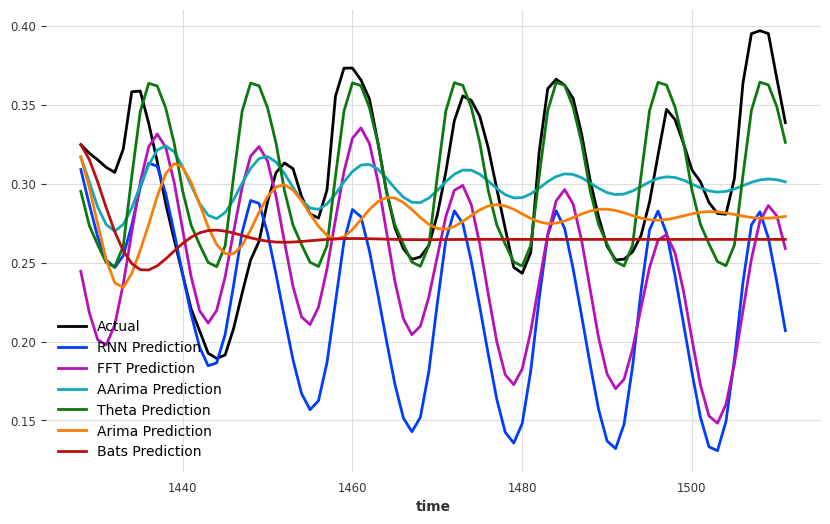

In [16]:
plt.figure(figsize=(10, 6))
# train.plot(label='Lookback')
test_one_series_actual.plot(label='Actual')
RNN_forecast[series_num].plot(label='RNN Prediction')
FFT_forecast[series_num].plot(label='FFT Prediction')
AArima_forecast[series_num].plot(label='AArima Prediction')
# ExpoSmooth_forecast.plot(label='Expo Prediction')
Theta_forecast[series_num].plot(label='Theta Prediction')
Arima_forecast[series_num].plot(label='Arima Prediction')
Bats_forecast[series_num].plot(label='Bats Prediction')
plt.legend()
